In [1]:
# run XGBoost with early stopping
# use SHAP values to calculate feature importances

import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost
from scipy.stats import pearsonr
import pickle
import matplotlib
from matplotlib import pylab as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

param_grid = {"learning_rate": [0.03],
              "objective":['reg:linear'], # change eval metric to rmse
              #"objective":['count:poisson'], # change the eval_metric to 'poisson-nloglik'
              #"reg_alpha": [0e0,0.1,0.3,1e0,3e0,10e0],
              #"reg_lambda": [0e0,0.1,0.03,1e0,3e0,10e0],
              "seed": [np.random.randint(1e6)],
              #"max_depth": [2,3,5,7],
              "n_jobs": [-1],
              "colsample_bytree": [0.9],
              "subsample": [0.66],
              "missing": [np.nan], 
              "n_estimators": [2000]}

def xgb_cv(X_tr,Y_tr,X_t,Y_t,X_h,Y_h,title,to_plot=True):

    # find best_params
    test_score = np.zeros(len(ParameterGrid(param_grid)))
    
    regressors = []
    for i in range(len(ParameterGrid(param_grid))):
        XGB = xgboost.XGBRegressor()
        # set XGB parameters
        g = ParameterGrid(param_grid)[i]
        XGB.set_params(**g)
        # do early stopping
        XGB.fit(X_tr,Y_tr,early_stopping_rounds=50, eval_metric='rmse', \
                eval_set=[(X_t, Y_t)], verbose=False)
        # collect test scores
        test_score[i] = XGB.best_score
        regressors.append(XGB)

    # choose best parameters on scores
    indx_para = np.where(test_score == np.min(test_score))[0]
    best_params = np.array(ParameterGrid(param_grid))[indx_para[0]]
    
    Y_pred = XGB.predict(X_h,ntree_limit=XGB.best_ntree_limit)
    X_shap = XGB.get_booster().predict(xgboost.DMatrix(X_h),pred_contribs=True,ntree_limit=XGB.best_ntree_limit)[:,:-1]

    if to_plot:
        print '   nr trees: ',XGB.best_ntree_limit
        print '   RMSE: ',np.sqrt(mean_squared_error(Y_h, Y_pred))
        print '   mean averaged error: ',np.mean(np.abs(Y_h-Y_pred))
        print '   R2 score: ',r2_score(Y_h, Y_pred)
        
        plt.figure(figsize=(6.4*2e0,4.8))
        plt.subplot(121)
        plt.plot(Y_h,Y_pred,'o')
        plt.plot(range(100),range(100))
        plt.xlim([-1,np.max(Y_h)])
        plt.ylim([-1,np.max(Y_h)])
        plt.xlabel('true values')
        plt.ylabel('predicted values')
        plt.title(title)
        
        plt.subplot(122)
        plt.plot(Y_pred,(Y_h-Y_pred),'o')
        plt.plot(range(100),np.zeros(100))
        plt.xlim([-1,np.max(Y_h)])
        plt.xlabel('predicted values')
        plt.ylabel('residuals (true - predicted)')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    return best_params,test_score[indx_para[0]],regressors[indx_para[0]],Y_pred,X_shap


In [2]:
# prepare features and target variables

np.random.seed(0)

df = pd.read_csv('../data/combined_dataset_daily.csv')

# target variables:
Y_T = df['TurtleNumber']
Y_P = df['PeopleNumber']

# Y_T = np.log10(df['TurtleNumber'])
# Y_T[df['TurtleNumber'] == 0] = -1
# Y_P = np.log10(df['PeopleNumber'])
# Y_P[df['PeopleNumber'] == 0] = -1

# date
datetime = df['Date']
# remove columns
df.drop(['TurtleNumber','PeopleNumber','Date'],axis=1,inplace=True)
# features
X = df
# add datetime related features
X['Year'] = pd.to_datetime(datetime).dt.year
X['Month'] = pd.to_datetime(datetime).dt.month
X['sin_day'] = np.sin(1e0*pd.to_datetime(datetime).dt.dayofyear / 365e0*np.pi)
X['float_day'] = pd.to_datetime(datetime).dt.dayofyear / 365e0
X['weekday'] = pd.to_datetime(datetime).dt.weekday
X['weekend'] = (pd.to_datetime(datetime).dt.weekday > 4).astype(int)

# add autocorrelation features
# if previous day is not measured, add np.nan
days = np.array([d[:10] for d in np.array(datetime)])
date_range = np.array([d[:10] for d in pd.date_range(days[0],days[-1]).astype(str)])

f_mean_1 = np.zeros(len(days))
f_mean_2 = np.zeros(len(days))

for i in range(len(days)):
    if days[i-1] in date_range:
        f_mean_1[i] = np.array(Y_T)[i-1]
    else:
        f_mean_1[i] = np.nan
    if days[i-2] in date_range:
        f_mean_1[i] = np.array(Y_T)[i-2]
    else:
        f_mean_2[i] = np.nan
        
X['mean_turtles_1'] = f_mean_1
X['mean_turtles_2'] = f_mean_2


f_mean_1 = np.zeros(len(days))
f_mean_2 = np.zeros(len(days))

for i in range(len(days)):
    if days[i-1] in date_range:
        f_mean_1[i] = np.array(Y_P)[i-1]
    else:
        f_mean_1[i] = np.nan
    if days[i-2] in date_range:
        f_mean_1[i] = np.array(Y_P)[i-2]
    else:
        f_mean_2[i] = np.nan
X['mean_human_1'] = f_mean_1
X['mean_human_2'] = f_mean_2


# # feature combination
# columns = list(X_T.columns)
# columns = columns[:-24] + columns[-15:]
# print columns
# for c in range(len(columns)):
#     for cc in range(c+1):
#         X_T[columns[c]+' * '+columns[cc]] = X_T[columns[c]]*X_T[columns[cc]]

# columns = list(X_P.columns)
# columns = columns[:-24] + columns[-15:]
# print columns
# for c in range(len(columns)):
#     for cc in range(c+1):
#         X_P[columns[c]+' * '+columns[cc]] = X_P[columns[c]]*X_P[columns[cc]]

print list(X.columns)
print np.min(datetime),np.max(datetime)
print np.shape(X)

['Nr_Volunteers', 'daily_mean_tide', 'daily_min_tide', 'daily_max_tide', 'daily_stdev_tide', 'total_count_1_day', 'domestic_count_1_day', 'int_total_count_1_day', 'int_japan_count_1_day', 'int_other_count_1_day', 'total_count_2_day', 'domestic_count_2_day', 'int_total_count_2_day', 'int_japan_count_2_day', 'int_other_count_2_day', 'total_count_3_day', 'domestic_count_3_day', 'int_total_count_3_day', 'int_japan_count_3_day', 'int_other_count_3_day', 'total_count_4_day', 'domestic_count_4_day', 'int_total_count_4_day', 'int_japan_count_4_day', 'int_other_count_4_day', 'total_count_5_day', 'domestic_count_5_day', 'int_total_count_5_day', 'int_japan_count_5_day', 'int_other_count_5_day', 'total_count_6_day', 'domestic_count_6_day', 'int_total_count_6_day', 'int_japan_count_6_day', 'int_other_count_6_day', 'total_count_7_day', 'domestic_count_7_day', 'int_total_count_7_day', 'int_japan_count_7_day', 'int_other_count_7_day', 'total_count_8_day', 'domestic_count_8_day', 'int_total_count_8_day

978
[ 22  45  91 182 365 730]
*********
22
*********
   RMSE:  5.8449440665
   mean abs error:  4.75700751752
   R2 score:  0.100882182484


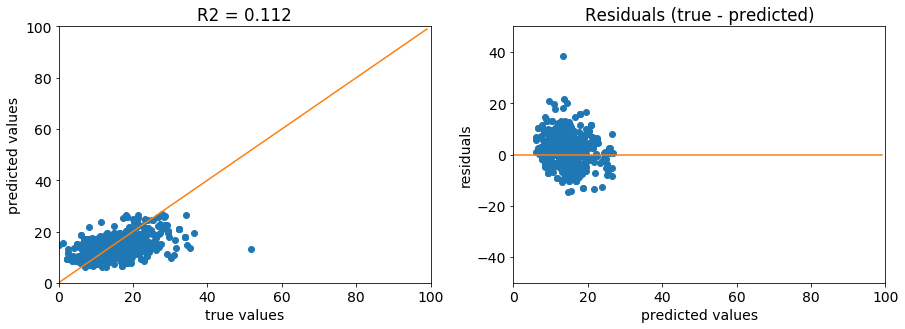

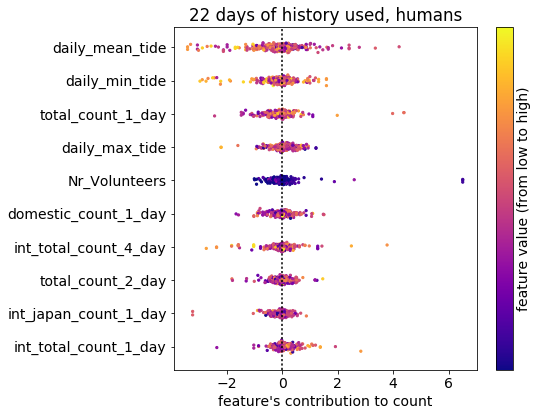

*********
45
*********
   RMSE:  5.67403399912
   mean abs error:  4.4878258234
   R2 score:  0.09377138939


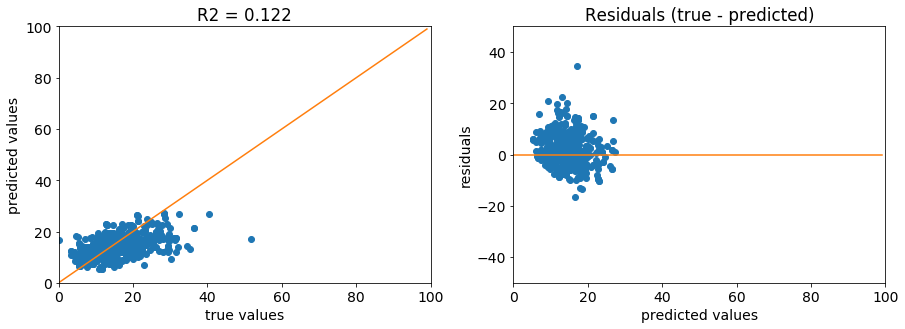

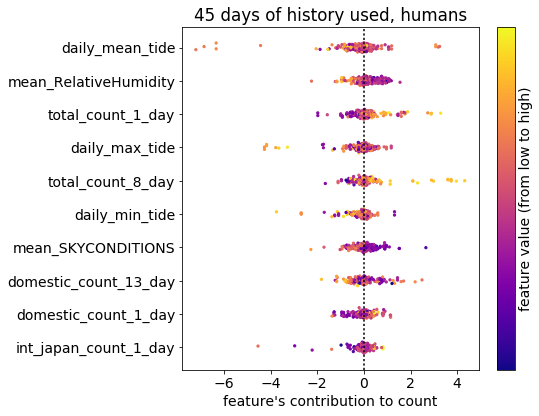

*********
91
*********
   RMSE:  6.33800356203
   mean abs error:  5.14246260297
   R2 score:  -0.0390786703385


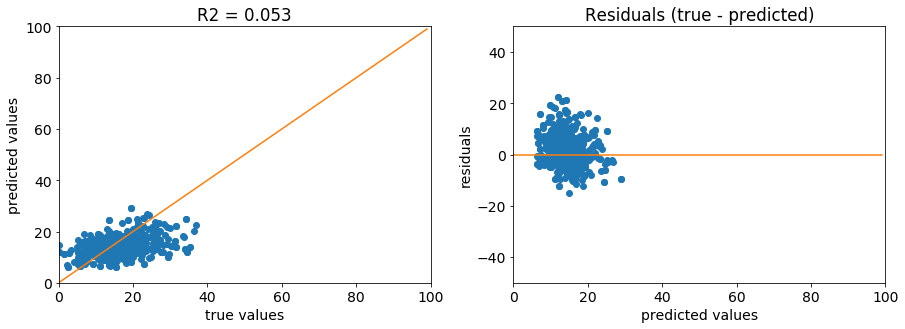

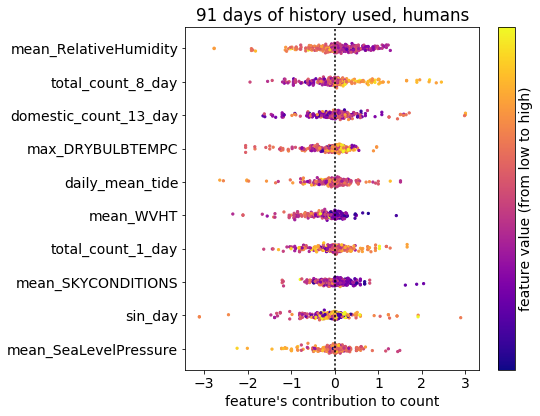

*********
182
*********
   RMSE:  5.83444711472
   mean abs error:  4.69437203609
   R2 score:  0.0425032949096


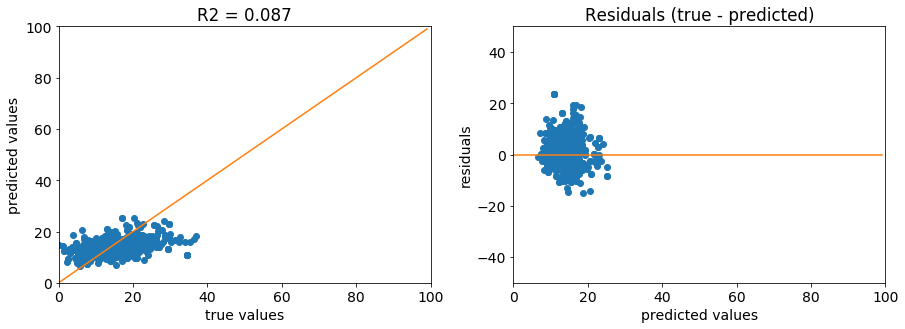

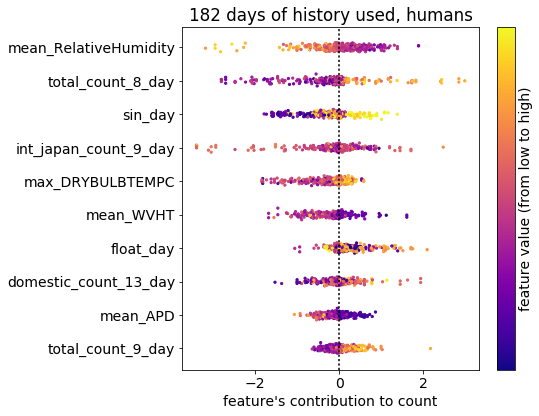

*********
365
*********
   RMSE:  5.53371213697
   mean abs error:  4.30149334497
   R2 score:  0.0881847397137


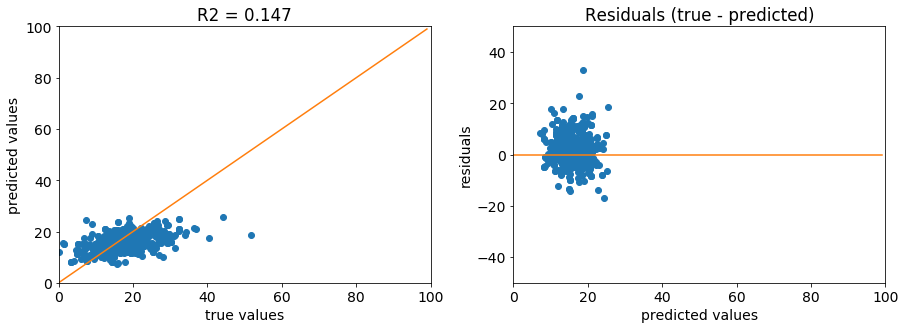

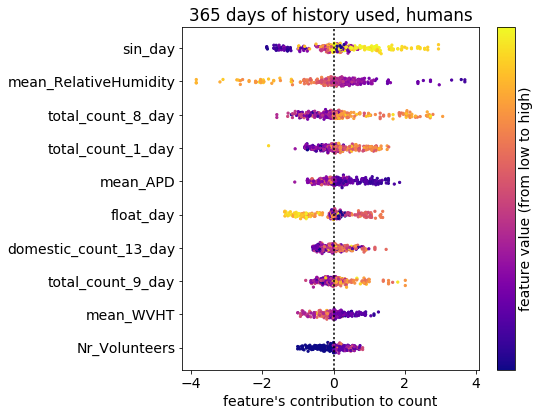

*********
730
*********
   RMSE:  5.95431736765
   mean abs error:  4.71446664533
   R2 score:  -0.319498625718


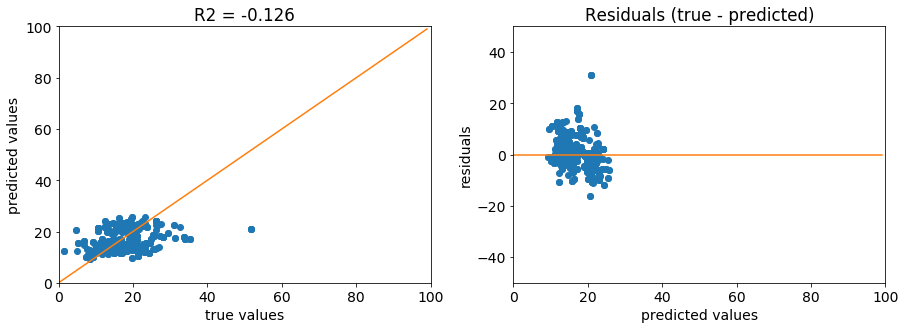

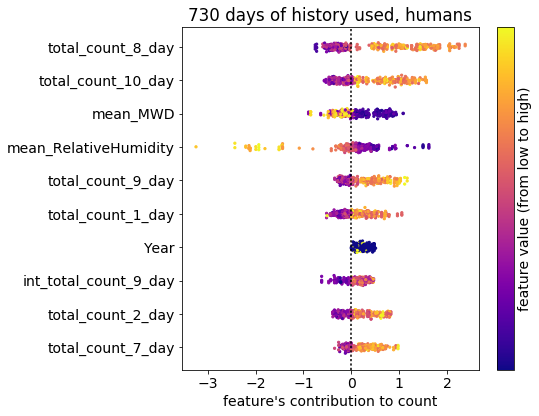

[ 0.10088218  0.09377139 -0.03907867  0.04250329  0.08818474 -0.31949863]


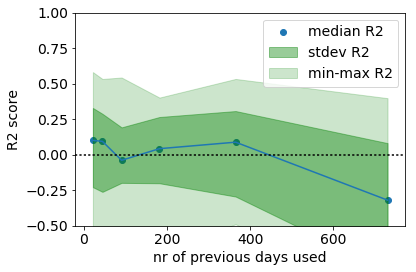

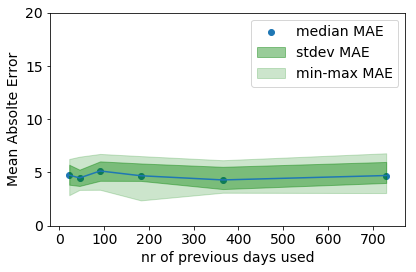

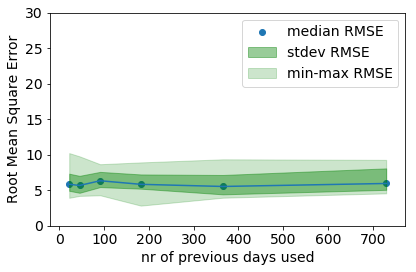

In [5]:
# CV pipeline mimicking future usage
np.random.seed(0)
# collect unique days
datetime = np.array(datetime)

days = np.array([d[:10] for d in datetime])
unique_days = sorted(np.unique(days))
print len(unique_days)

n_sim = 30
nr_days_holdout = 20
nr_models = 1
#dt_days = np.linspace(20,800,num=40,endpoint=True)
dt_days = np.array([365/16,365/8,365/4,365/2,365,365*2])
#dt_days = np.concatenate((np.arange(1,9)*365/16,183 + np.arange(1,5)*365/8,365 + np.arange(1,3)*365/2),axis=0)
#dt_days = np.arange(1,33)*365/16
R2_grid = np.zeros([len(dt_days),n_sim])
mae_grid = np.zeros([len(dt_days),n_sim])
rmse_grid = np.zeros([len(dt_days),n_sim])
print dt_days

# turtles or humans to predict? 
Y = Y_P

feature_names = np.array(list(X.columns))
for t in range(len(dt_days)):
    print '*********'
    print dt_days[t]
    print '*********'
    
    if Y.name == 'TurtleNumber':
        we_predict = 'turtles'
    else:
        we_predict = 'humans'
        
    # random days
    indices = np.random.choice(np.arange(dt_days[t],len(unique_days)),size=(n_sim,nr_days_holdout))
    
    X_shap_all = np.empty([0,np.shape(X)[1]])
    X_h_all = np.empty([0,np.shape(X)[1]])
    
    Y_pred_total = []
    Y_h_total = []
    
    for n in range(n_sim):
        Y_all = []
        Y_pred_all = []   
        
        
        for i in range(nr_days_holdout):
            indx = int(indices[n,i])
            holdout_day = unique_days[indx]
            start_day = unique_days[indx - int(dt_days[t])]
            split_day = unique_days[indx - int(dt_days[t]*0.3)]

            # keep one day only in holdout
            Y_holdout = Y[days == holdout_day]
            X_holdout = X[days == holdout_day]

            # split data using split_day
            mask = (days < split_day)&(days >= start_day)
            X_train = X[mask]
            Y_train = Y[mask]
            mask = (days < holdout_day)&(days >= split_day)
            X_test = X[mask]
            Y_test = Y[mask]
            
            Y_pred = np.zeros(len(Y_holdout))
            X_shap = np.zeros(np.shape(X_holdout))
            for m in range(nr_models):
                best_params,best_score,XGB, Y_p, Y_s = xgb_cv(X_train,Y_train,X_test,Y_test,X_holdout,Y_holdout,'turtles',to_plot=False)
                Y_pred += Y_p
                X_shap += Y_s
            Y_pred = 1e0*Y_pred / nr_models
            X_shap = 1e0*X_shap / nr_models
                
            Y_pred_all.append(Y_pred)
            Y_all.append(Y_holdout)
            X_shap_all = np.concatenate((X_shap_all,X_shap),axis=0)
            X_h_all = np.concatenate((X_h_all,X_holdout),axis=0)
            
        Y_pred = np.array([item for sublist in Y_pred_all for item in sublist])
        Y_pred_total.append(Y_pred)
        
        Y_holdout = np.array([item for sublist in Y_all for item in sublist])
        Y_h_total.append(Y_holdout)
        
        R2_grid[t,n] = r2_score(Y_holdout, Y_pred)
        mae_grid[t,n] = np.mean(np.abs(Y_holdout-Y_pred))
        rmse_grid[t,n] = np.sqrt(mean_squared_error(Y_holdout, Y_pred))
        
        
        

    # show on example plot per dt_days[t]
    
    print '   RMSE: ',np.median(rmse_grid[t])
    print '   mean abs error: ',np.median(mae_grid[t])
    print '   R2 score: ',np.median(R2_grid[t])
    
    
    Y_pred = np.array([item for sublist in Y_pred_total for item in sublist])        
    Y_holdout = np.array([item for sublist in Y_h_total for item in sublist])

    plt.figure(figsize=(6.4*2e0,4.8))
    plt.subplot(121)
    plt.plot(Y_holdout,Y_pred,'o')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.plot(range(100),range(100))
    plt.xlabel('true values')
    plt.ylabel('predicted values')
    plt.title('R2 = '+str(np.around(r2_score(Y_holdout, Y_pred),3)))

    plt.subplot(122)
    plt.plot(Y_pred,Y_holdout-Y_pred,'o')
    plt.plot(range(100),np.zeros(100))
    plt.xlim([0,100])
    plt.ylim([-50,50])
    plt.xlabel('predicted values')
    plt.ylabel('residuals')
    plt.title('Residuals (true - predicted)')
    plt.tight_layout()
    plt.savefig('../results/Yt_Yp_'+we_predict+'_day'+str(dt_days[t])+'_nrmodels'+str(nr_models)+'_daily.png',dpi=150)

    plt.show()
    
    # prepare feature importance X_shap plot
    sorted_indcs = np.argsort(np.mean(np.abs(X_shap_all),axis=0))[::-1]

    plt.figure(figsize=(8,6))
    for i in range(10):
        plt.scatter(X_shap_all[:,sorted_indcs[i]],np.zeros(np.shape(X_shap_all)[0])+\
                    (10-1-i)+np.random.normal(0e0,0.05,size=np.shape(X_shap_all)[0]),\
                    s=5,c=X_h_all[:,sorted_indcs[i]],cmap='plasma')
    plt.axvline(0e0,linestyle='dotted',color='k')
    plt.yticks(range(10)[::-1],feature_names[sorted_indcs[:10]])
    plt.xlabel("feature's contribution to count")
    plt.colorbar(ticks=[],label='feature value (from low to high)')
    plt.legend(loc=4)
    plt.title(str(dt_days[t])+' days of history used, '+we_predict)
    plt.tight_layout()
    plt.savefig('../results/feature_imps_'+we_predict+'_day'+str(dt_days[t])+'_nrmodels'+str(nr_models)+'_daily.png',dpi=150)
    plt.show()
    plt.close()


print np.median(R2_grid,axis=1)
plt.plot(dt_days,np.median(R2_grid,axis=1))
plt.scatter(dt_days,np.median(R2_grid,axis=1),label='median R2')
plt.fill_between(dt_days,np.percentile(R2_grid,16,axis=1),\
                 np.percentile(R2_grid,84,axis=1),alpha=0.4,\
                 label='stdev R2',color='g')
plt.fill_between(dt_days,np.percentile(R2_grid,0,axis=1),\
                 np.percentile(R2_grid,100,axis=1),alpha=0.2,\
                 label='min-max R2',color='g')
plt.axhline(0,color='k',linestyle=':')
plt.ylabel('R2 score')
plt.xlabel('nr of previous days used')
plt.legend()
plt.ylim([-0.5,1])
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_R2_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'_daily.png',dpi=150)
plt.show()


plt.plot(dt_days,np.median(mae_grid,axis=1))
plt.scatter(dt_days,np.median(mae_grid,axis=1),label='median MAE')
plt.fill_between(dt_days,np.percentile(mae_grid,16,axis=1),\
                 np.percentile(mae_grid,84,axis=1),alpha=0.4,\
                 label='stdev MAE',color='g')
plt.fill_between(dt_days,np.percentile(mae_grid,0,axis=1),\
                 np.percentile(mae_grid,100,axis=1),alpha=0.2,\
                 label='min-max MAE',color='g')
plt.ylabel('Mean Absolte Error')
plt.xlabel('nr of previous days used')
plt.ylim([0,20])
plt.legend()
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_MAE_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'_daily.png',dpi=150)
plt.show()

plt.plot(dt_days,np.median(rmse_grid,axis=1))
plt.scatter(dt_days,np.median(rmse_grid,axis=1),label='median RMSE')
plt.fill_between(dt_days,np.percentile(rmse_grid,16,axis=1),\
                 np.percentile(rmse_grid,84,axis=1),alpha=0.4,\
                 label='stdev RMSE',color='g')
plt.fill_between(dt_days,np.percentile(rmse_grid,0,axis=1),\
                 np.percentile(rmse_grid,100,axis=1),alpha=0.2,\
                 label='min-max RMSE',color='g')
plt.ylabel('Root Mean Square Error')
plt.xlabel('nr of previous days used')
plt.ylim([0,30])
plt.legend()
plt.tight_layout()
plt.savefig('../results/'+we_predict+'_RMSE_'+param_grid['objective'][0][:3]+'_'+str(n_sim)+'_'+str(nr_days_holdout)+'_'+str(nr_models)+'_daily.png',dpi=150)
plt.show()



In [4]:
# simple CV


# # split dataset randomly
# X_t, X_test, Y_T_t, Y_T_test, Y_P_t, Y_P_test = train_test_split(X,Y_T,Y_P,test_size=0.2) 
# X_train, X_holdout, Y_T_train, Y_T_holdout, Y_P_train, Y_P_holdout = train_test_split(X_t,Y_T_t,Y_P_t,test_size=0.25) 
# print np.shape(X)
# print np.shape(X_train)
# print np.shape(X_test)
# print np.shape(X_holdout)


# print 'SPLIT DATASET RANDOMLY'
# # predict turtles
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_T_train,X_test,Y_T_test,X_holdout,Y_T_holdout,'turtles')
# # predict humans
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_P_train,X_test,Y_P_test,X_holdout,Y_P_holdout,'humans')


# # holdout non-random, train-test random
# mask_holdout = (X['Year']==2017)|((X['Year']==2016) & ((X['Month']>8 )))
# X_holdout = X.loc[mask_holdout]
# Y_T_holdout = Y_T.loc[mask_holdout]
# Y_P_holdout = Y_P.loc[mask_holdout]
# X_train, X_test, Y_T_train, Y_T_test, Y_P_train, Y_P_test = train_test_split(X.loc[~mask_holdout],Y_T.loc[~mask_holdout],Y_P.loc[~mask_holdout],test_size=0.2) 
# print np.shape(X)
# print np.shape(X_train)
# print np.shape(X_test)
# print np.shape(X_holdout)
# print 'HOLDOUT NON-RANDOM, TRAIN-TEST RANDOM'
# # predict turtles
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_T_train,X_test,Y_T_test,X_holdout,Y_T_holdout,'turtles')
# # predict humans
# best_params,best_score,XGB,Y_pred = xgb_cv(X_train,Y_P_train,X_test,Y_P_test,X_holdout,Y_P_holdout,'humans')


# split the dataset based on time
mask_test = (X['Year']==2016) & ((X['Month']<=8 )&(X['Month']>2))
mask_holdout = (X['Year']==2017)|((X['Year']==2016) & ((X['Month']>8 )))
X_T_train = X_T.loc[~(mask_test|mask_holdout)]
X_P_train = X_P.loc[~(mask_test|mask_holdout)]
Y_T_train = Y_T.loc[~(mask_test|mask_holdout)]
Y_P_train = Y_P.loc[~(mask_test|mask_holdout)]
X_T_test = X_T.loc[mask_test]
X_P_test = X_P.loc[mask_test]
Y_T_test = Y_T.loc[mask_test]
Y_P_test = Y_P.loc[mask_test]
X_T_holdout = X_T.loc[mask_holdout]
X_P_holdout = X_P.loc[mask_holdout]
Y_T_holdout = Y_T.loc[mask_holdout]
Y_P_holdout = Y_P.loc[mask_holdout]
print np.shape(X_T)
print np.shape(X_P_train)
print np.shape(X_T_test)
print np.shape(X_P_holdout)

print 'SPLIT BASED ON TIME'
# predict turtles
best_params,best_score,XGB,Y_pred,X_shap = xgb_cv(X_T_train,Y_T_train,X_T_test,Y_T_test,X_T_holdout,Y_T_holdout,'turtles')
# predict humans
best_params,best_score,XGB,Y_pred,X_shap = xgb_cv(X_P_train,Y_P_train,X_P_test,Y_P_test,X_P_holdout,Y_P_holdout,'humans')




NameError: name 'X_T' is not defined